In [1]:
# Внимание!!! Важно, что бы файлы с данными и исполняемый файл находились в одной папке, 
# тогда пути к тестовым и тренировочным наборам будут содержать только имена файлов.
# 
# В пути к тренировочным и тестовым данным запрежается использовать абсалютную адресацию, 
# то есть адресацию, в которой присутствуют имена папок. Путь должен содержать только имя файла.
#
# Напоминание: под моделью машинного обучения понимаются все действия с исходными данными, 
# которые необходимо произвести, что бы сопоставить признаки целевому значению.

### Область работы 1 (библиотеки)

In [2]:
# Данный блок в области 1 НЕ выполняется преподавателем
# 
# данный блок предназначен только для подключения необходимых библиотек
# запрещается подключать библиотеки в других блоках
# запрещается скрывать предупреждения системы
# установка дополнительных библиотек размещается прямо здесь (обязательно закоментированы)
# pip install

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold

### Область работы 2 (поиск  модели .... )

In [4]:
# Данный блок(и) НЕ выполняются преподавателем в области 2
# блок(и) предназначены для поиска лучшей модели 
# должен быть понятен и очевиден отбор параметров модели
# оставляйте свои комментарии и разъяснения
# 
# Запрещается размещать данные блоки за пределами обасти 2
# Все блоки данной области должны быть выполнены
#
# ЗАПРЕЩАЕТСЯ ИСПОЛЬЗОВАТЬ ТЕСТОВЫЙ НАБОР
#
# Путь к тренировочному набору
# 
path_train = 'train.csv' # содержит только имя файла, без имен папок !!!

# Для начала я подгружаю данные из csv файла и дропаю дубликаты(их в наборе не оказалось), целевая переменная для меня хорошее вино, вину с качеством >= 7 присваиваю единицу, плохому - ноль. 

In [5]:
data = pd.read_csv(path_train)
data.drop_duplicates()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.4,0.17,0.34,1.5,0.091,42.0,135.0,0.99380,3.25,0.49,9.6,7
1,8.0,0.42,0.36,5.0,0.037,34.0,101.0,0.99200,3.13,0.57,12.3,7
2,6.7,0.27,0.25,8.0,0.053,54.0,202.0,0.99610,3.22,0.43,9.3,5
3,5.2,0.21,0.31,1.7,0.048,17.0,61.0,0.98953,3.24,0.37,12.0,7
4,7.6,0.48,0.37,1.2,0.034,5.0,57.0,0.99256,3.05,0.54,10.4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1720,6.9,0.39,0.22,4.3,0.030,10.0,102.0,0.99300,3.00,0.87,11.6,4
1721,6.4,0.34,0.10,1.1,0.048,19.0,84.0,0.99270,3.21,0.38,9.8,5
1722,7.0,0.53,0.43,6.1,0.029,6.0,76.0,0.99118,3.08,0.50,12.5,8
1723,5.9,0.17,0.29,3.1,0.030,32.0,123.0,0.98913,3.41,0.33,13.7,7


## Предварительно я использовал pandas_profiling для проверки данных, density коррелирует сильно с другими столбцами, но удаление/какая-то работа с датафреймом не приводит к улучшению результата, поэтому заниматься датасатанизмом я не стал, прикладывать репорт тоже не вижу смысла, из-за него ломается отрисовка графиков seaborn и matplotlib

# Классы дизбалансные, хорошего вина 35%... с его определением возникают проблемы

In [6]:
data[data['quality'] == 1]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


# Сплитую данные на тренировочные и тестовые, изменял параметры тест сайза 30% выдаёт лучшие результаты

In [7]:
data['quality'] = data['quality'].apply(lambda x: 1 if x >= 7 else 0)
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['quality']), data.quality, test_size=0.3)

# Все модели я прогонял сначала отдельно, они давали +- одинаковые результаты: Logreg даёт более высокий пресижн и более низкий рекол, NB выдаёт высокий рекол, но относительно малый пресижн, KNN - что-то среднее между ними, поэтому я решил прогнать все алгоритмы со всеми возможными параметрами в одной решётке... 
## Кстати о метрике, нужно с ней определиться: Accuracy сразу мимо, остаются 3 основных кандидата: Recall, precision и f1, f1 усредняет рекол и пресижн, думаю, в условиях соревнования нужно рисковать. Что хуже: выбирать хорошее вино под видом плохого или упускать хорошее вино? Ошибка первого рода или второго? Как мне кажется намного хуже отдать много денег за "хорошее" вино, а получить совсем не то, что ожидал, наверное, не этого люди хотят от покупки дорогого и хорошего вина, максимизирую $Precision$ !

In [8]:
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()] # все скалеры, о которых говорили на паре
parameters = [
    {
        'preprocessing': scalers,
        'classifier': [KNeighborsClassifier()], # соседи
        'classifier__n_neighbors': np.arange(1, 25), # 25 соседей хватает, на тестовых прогонах было 2 лучших результата ~ 10 и ~ 20
        'classifier__weights': ['uniform'], # убрал distance, модель переобучается на тренировочном наборе
        'classifier__p': [1, 2 , 3] # метрики: манхетенская, евклидова, миньковского
    },
    {
        'preprocessing': scalers,
        'classifier': [LogisticRegression()], # логистическая регрессия
        'classifier__penalty': ['l1'], # штраф l1 удаляет признаки практически не влияющие на ответ (количество признаков уменьшается)
        'classifier__solver': ['liblinear', 'saga'] 
    },
    {
        'preprocessing': scalers,
        'classifier': [LogisticRegression()], # регрессия
        'classifier__penalty': ['l2'], # штраф l2 штрафует признаки практически не влияющие на ответ (количество признаков не меняется)
        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 
    },
    {
        'preprocessing': scalers,
        'classifier': [LogisticRegression()], # регрессия
        'classifier__penalty': ['none'], # не штрафуем
        'classifier__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'] 
    },
    {
        'preprocessing': scalers,
        'classifier': [GaussianNB()] #  гауссовский наивный байес
    },
    {
        'preprocessing': scalers,
        'classifier': [MultinomialNB()], # еще какой-то наивный байес
        'classifier__alpha': np.linspace(0.1, 1, 10)
    },
    {
        'preprocessing': scalers,
        'classifier': [BernoulliNB()], # наивный байес бернулли
        'classifier__alpha': np.linspace(0.1, 1, 10)
    }
]
## сила регуляризации C не стал менять, результаты не улучшались, либо я неправильно подбирал баланс

# Создаю пайплайн, кросс валидацию решил выбрать $StratifiedKFold$, изначально ставил шаффл сплит, но после дополнительных прогонов, StratifiedKFold показал результаты лучше
# Много предупреждений из-за скалеров, не всем алгоритмам нравятся отрицательные значения, но что поделаешь, придется посмотреть на много красных строк

In [9]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), ('classifier', KNeighborsClassifier())])
cv = StratifiedKFold(n_splits=5) 
grid = GridSearchCV(pipe, parameters, cv=cv, return_train_score=True)
grid.fit(X_train, y_train);

D:\for conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\for conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\for conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\for conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\for conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\for conda\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
D:\f

# Посмотрим, какие параметры "победили"

In [10]:
grid.best_params_, grid.best_score_, grid.score(X_test, y_test)

({'classifier': LogisticRegression(),
  'classifier__penalty': 'none',
  'classifier__solver': 'sag',
  'preprocessing': RobustScaler()},
 0.7497959603580124,
 0.777992277992278)

# Однозачно нулевой класс я обрабатываю лучше

In [11]:
grid.best_params_, grid.best_score_, grid.score(X_test, y_test)
print(classification_report(y_test, grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       323
           1       0.77      0.59      0.67       195

    accuracy                           0.78       518
   macro avg       0.77      0.74      0.75       518
weighted avg       0.78      0.78      0.77       518



# Выведу датафрейм с результатами работы моей решётки, главное не отобрать переобученную модель ( у неё на трейн скорах будут 1.0)

In [12]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,326,330,297,310,289,298,301,302,305,306,...,357,358,361,362,365,366,369,370,373,374
mean_fit_time,0.0158,0.016599,0.007604,0.016805,0.007601,0.010001,0.005205,0.007596,0.004201,0.005202,...,0.003001,0.004401,0.003201,0.004201,0.003001,0.004401,0.003201,0.004401,0.002801,0.004601
std_fit_time,0.000982,0.000494,0.000492,0.000742,0.0008,0.000627,0.000397,0.000793,0.000399,0.000402,...,0.000633,0.00049,0.000401,0.0004,0.0,0.00049,0.000401,0.00049,0.0004,0.00049
mean_score_time,0.002006,0.001603,0.001402,0.001801,0.001802,0.001801,0.001598,0.001203,0.0012,0.001198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std_score_time,0.000006,0.000487,0.00049,0.0004,0.000401,0.000401,0.000488,0.000399,0.000401,0.000396,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
param_classifier,LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),LogisticRegression(),...,MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB(),MultinomialNB()
param_classifier__n_neighbors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_classifier__p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_classifier__weights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
param_preprocessing,RobustScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),...,StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler(),StandardScaler(),RobustScaler()
param_classifier__penalty,none,none,l2,l2,l1,l2,l2,l2,l2,l2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Игра "Найди 10 отличий в боксплотах"

D:\for conda\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


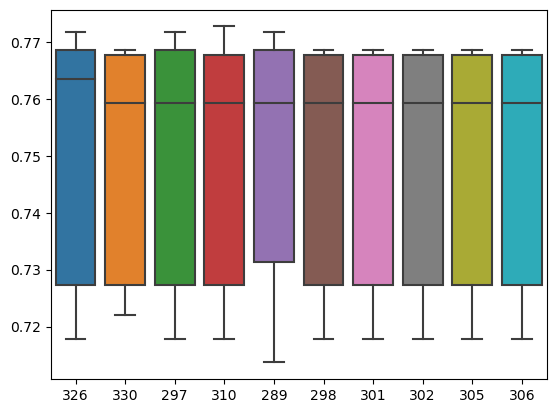

In [13]:
mask = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask].iloc[:,:10]
sns.boxplot(data=tabl);

# Посмотрел на пороговое значение, удалось улучшить модель на пару процентов, главное не заигрываться и не выкручивать его на максимум, да, пресижн будет расти еще сильнее (немного) но реколу становится очень плохо

In [32]:
y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
threshold = 0.56
y_pred = (y_proba >= threshold).astype(int)

# Посмотрю на матрицу ошибок

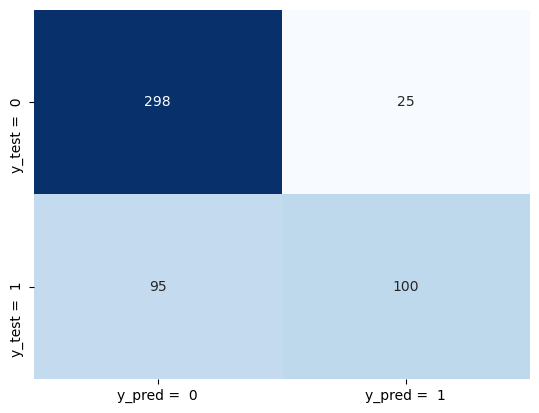

In [34]:
matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(matrix, annot=True, fmt='g', cbar=None, cmap="Blues", 
            xticklabels=['y_pred =  0', 'y_pred =  1'], yticklabels=['y_test =  0', 'y_test =  1']);

# Вывожу 3 основные метрики, смотрю прежде всего на precision

In [33]:
print('recall:    ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('f1:        ', f1_score(y_test, y_pred))

recall:     0.5128205128205128
precision:  0.8
f1:         0.625


## Немного красивого графика рок-аук, просто чтобы был

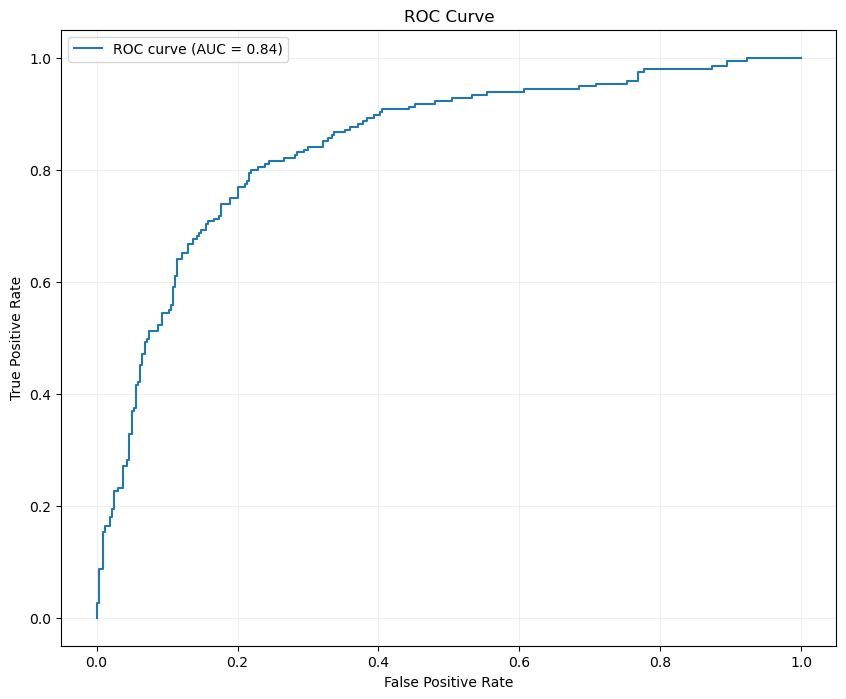

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid(alpha=0.2)
plt.show()

# Из всех моих прогонов выдавали лучшие результаты регрессия и соседи, но 0.8 пресижн при 0.51 реколе не было еще ( в среднем 0.7 пресижн 0.6 рекол)
## Использую модель: ({'classifier': LogisticRegression(), 'classifier__penalty': 'none', 'classifier__solver': 'sag', 'preprocessing': RobustScaler()},)